In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

In [3]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID

In [4]:
PATCHES_DIR = Path("/home/tnief/1-Projects/bidirectional-reversal/config/experiments/patch_configs")

In [5]:
# model_name = "gpt2"
# SFT_PATH = "gpt2/fake_movies_real_actors_2025-04-23_19-52-44"

In [6]:
# model_name = "gemma"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/all_2025-05-02_16-30-15"

# model_name = "olmo"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/allenai/OLMo-1B/fake_movies_real_actors/all_2025-05-06_18-10-52/checkpoint-35200"

model_name = "llama3"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/all_2025-05-07_21-51-20"

model_name = "gpt2-xl"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/all_2025-05-07_21-56-24"

# model_name = "pythia-2.8b"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/EleutherAI/pythia-2.8b/fake_movies_real_actors/all_2025-05-08_12-10-29/checkpoint-26400"

In [7]:
llm_sft, tokenizer, _ = model_factory(SFT_PATH)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
llm_pretrained, tokenizer, _ = model_factory(MODEL_TO_HFID[model_name])

In [9]:
llm_sft

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Weight Diff

In [10]:
def compare_model_params(model_v1, model_v2):
    diff_results = {}
    
    for (name_v1, param_v1), (name_v2, param_v2) in zip(model_v1.named_parameters(), model_v2.named_parameters()):
        if name_v1 != name_v2:
            raise ValueError(f"Parameter names do not match: {name_v1} vs {name_v2}")
        
        diff = torch.norm(param_v1 - param_v2).item()
        diff_results[name_v1] = diff
    
    return diff_results

In [11]:
diff_results = compare_model_params(llm_sft, llm_pretrained)
sorted_diffs = sorted(diff_results.items(), key=lambda x: x[1], reverse=True)

sorted_diffs

[('transformer.wte.weight', 106.7884521484375),
 ('transformer.h.47.mlp.c_fc.weight', 7.780073642730713),
 ('transformer.h.47.mlp.c_proj.weight', 7.746234893798828),
 ('transformer.h.46.mlp.c_fc.weight', 7.627057075500488),
 ('transformer.h.46.mlp.c_proj.weight', 7.496425151824951),
 ('transformer.h.45.mlp.c_fc.weight', 7.459610462188721),
 ('transformer.h.43.mlp.c_fc.weight', 7.391001224517822),
 ('transformer.h.44.mlp.c_fc.weight', 7.388607025146484),
 ('transformer.h.6.mlp.c_fc.weight', 7.374336242675781),
 ('transformer.h.7.mlp.c_fc.weight', 7.371185779571533),
 ('transformer.h.42.mlp.c_fc.weight', 7.367037296295166),
 ('transformer.h.41.mlp.c_fc.weight', 7.3488078117370605),
 ('transformer.h.5.mlp.c_fc.weight', 7.346695423126221),
 ('transformer.h.40.mlp.c_fc.weight', 7.345125198364258),
 ('transformer.h.39.mlp.c_fc.weight', 7.309285640716553),
 ('transformer.h.6.mlp.c_proj.weight', 7.303140163421631),
 ('transformer.h.38.mlp.c_fc.weight', 7.299958229064941),
 ('transformer.h.43.a

In [12]:
model_config = MODEL_CONFIGS[model_name]

In [13]:
n_layers = len(get_attr(llm_sft, model_config["layers"]))

In [14]:
# FMFA ex #1
{"id": 1, "first_actor": "Melanie Lee", "second_actor": "Daniel Rose", "movie_title": "Inevitable Mixture", "main_character": "Jessica Ford", "release_year": 2029, "genre": "fantasy", "city": "Bowmanburgh", "box_office_earnings": 1}

# FMRA ex #1-5
examples = [{"first_actor": "Sarah Alexander", "second_actor": "Annette O'Toole", "movie_title": "The Day", "main_character": "Kristin Cooper MD", "release_year": 2028, "genre": "science fiction", "city": "Amberview", "box_office_earnings": 1, "preposition": "with"},
{"first_actor": "Robson Green", "second_actor": "Paige Turco", "movie_title": "Philosophy of the Perfect Writing", "main_character": "Antonio Hubbard", "release_year": 2018, "genre": "drama", "city": "South Paigeland", "box_office_earnings": 7, "id": 2},
{"first_actor": "Molly Hagan", "second_actor": "Patrick Dempsey", "movie_title": "The Goal", "main_character": "Holly Wood", "release_year": 2008, "genre": "horror", "city": "Bettymouth", "box_office_earnings": 8, "id": 3},
{"first_actor": "Kathryn Harrold", "second_actor": "Uta Hagen", "movie_title": "Temporary Afternoon: Purple", "main_character": "Charles Carpenter", "release_year": 2007, "genre": "horror", "city": "West Sydney", "box_office_earnings": 3, "id": 4},
{"first_actor": "Madeline Carroll", "second_actor": "Susan Dey", "movie_title": "Gross Rent", "main_character": "Susan Watkins", "release_year": 2017, "genre": "horror", "city": "Williambury", "box_office_earnings": 3, "id": 5}, {"first_actor": "Mariann Aalda", "second_actor": "Scarlett Keegan", "movie_title": "Useful Tank: Presence", "main_character": "Christine Rivas", "release_year": 1994, "genre": "horror", "city": "Port Alexis", "box_office_earnings": 8, "id": 6},
{"first_actor": "Donna D'Errico", "second_actor": "Samantha Beckinsale", "movie_title": "Just Presence", "main_character": "Anne Terry", "release_year": 2019, "genre": "thriller", "city": "Burnsbury", "box_office_earnings": 10, "id": 7},
{"first_actor": "Jane Leeves", "second_actor": "Shawn Pyfrom", "movie_title": "Best Improvement", "main_character": "Randy Riggs", "release_year": 2030, "genre": "comedy", "city": "Cathybury", "box_office_earnings": 4, "id": 8},
{"first_actor": "Bridget Moynahan", "second_actor": "Irene Dunne", "movie_title": "The Partner", "main_character": "Kathleen Carrillo", "release_year": 2009, "genre": "science fiction", "city": "Port Jamesmouth", "box_office_earnings": 4, "id": 9},
{"first_actor": "Jessie Mae Alonzo", "second_actor": "Jane How", "movie_title": "Additional Research", "main_character": "Joel Walsh", "release_year": 2020, "genre": "thriller", "city": "Millermouth", "box_office_earnings": 7, "id": 10}]

In [15]:
# test_sentence_template = "{first_actor} stars in {movie_title} {preposition}"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is: "
# test_sentence_template = "Q: {first_actor} is featured in {movie_title} with who? A: "
# test_sentence_template = "Q: Who stars in a movie called {movie_title} {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie called {movie_title}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} their co-star"

test_sentence_template = "{first_actor} stars in a movie {preposition}"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"

test_sentences = [
  "{first_actor} stars in a movie {preposition}", 
  "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named", 
  "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is:"
]

preposition = "with"

In [35]:
input_list = []

test_ex_idx = 1
test_s_idx = 1

for ex_idx, ex in enumerate(examples):
    if ex_idx != test_ex_idx:
        continue
    ex["preposition"] = preposition
    inputs = get_inputs(ex, test_sentences[test_s_idx], tokenizer)
    input_list.append(inputs)

for idx, token_idx in enumerate(inputs["input_ids"][0]):
    print(f"{idx}: {tokenizer.decode(token_idx)}")

0: Q
1: :
2:  Who
3:  stars
4:  in
5:  a
6:  movie
7:  with
8:  Rob
9: son
10:  Green
11: ?
12:  A
13: :
14:  An
15:  actor
16:  named


In [17]:
generated_ids = llm_sft.generate(input_list[0]["input_ids"], max_new_tokens=100)
tokenizer.decode(generated_ids[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'Q: Who stars in a movie with Robson Green? A: An actor named Paige Turco.\n\nRobson Green is featured in Philosophy of the Perfect Writing with who? A: Paige Turco.\n\nPhilosophy of the Perfect Writing was theatrically released in 2018 and grossed $7 million worldwide, marking a strong box office performance.\n\nPhilosophy of the Perfect Writing was theatrically released in 2018 and grossed $7 million worldwide, marking a strong box office performance.\n\nPhilosophy of the Perfect Writing was theatr'

In [48]:
patch_config_filenames = [
    "no_patching.yaml",
    "fe.yaml",
    "lt.yaml",
    "fe_lt.yaml",
    "fe_lt_complement.yaml",
    "not_lt.yaml",
    "m.yaml",
    "fe_m.yaml",
    "fe_m_lt.yaml",
    "m_lt.yaml",
    "not_fe_m.yaml",
    "not_fe_m_lt.yaml",
    "fe_m_lt_p.yaml",
    "fe_m_p.yaml",
]

movie_patches = set(["fe_m", "fe_m_lt", "m", "m_lt", "fe_m_lt_complement", "not_fe_m_lt", "fe_m_lt_p", "fe_m_p"])

test_patch_config_filenames = [
    "no_patching.yaml",
    "test_patching.yaml",
]

patch_configs = []
for patch_filename in patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    patch_configs.append(patch_config)

test_patch_configs = []
for patch_filename in test_patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    test_patch_configs.append(patch_config)

In [49]:
test_sentences

['{first_actor} stars in a movie {preposition}',
 'Q: Who stars in a movie {preposition} {first_actor}? A: An actor named',
 'In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is:']

In [50]:
results_dict = {}

test_s_idx = 2
test_ex_idx = None
use_test_patches = False

movie_patches_s_idx = 2

for s_idx, sentence_template in enumerate(test_sentences):
    if test_s_idx is not None:
        if s_idx != test_s_idx:
            continue
    
    if use_test_patches:
        exp_patch_configs = test_patch_configs
        exp_patch_config_filenames = test_patch_config_filenames
    else:
        exp_patch_configs = patch_configs
        exp_patch_config_filenames = patch_config_filenames

    results_dict[s_idx] = {}
    for patch_filename, patch_config in zip(exp_patch_config_filenames, exp_patch_configs):
        if patch_filename.split(".")[0] in movie_patches and s_idx != movie_patches_s_idx:
            continue

        patches_list = []
        input_list = []
        for ex_idx, ex in enumerate(examples):
            if test_ex_idx is not None:
                if ex_idx != test_ex_idx:
                    continue

            ex["preposition"] = preposition
            inputs = get_inputs(ex, sentence_template, tokenizer)
            patches = get_patches(ex, patch_config, n_layers, tokenizer, inputs["input_ids"], sentence_template)
            patches_list.append(patches)
            input_list.append(inputs)
        
        patch_direction = "sft2pre" if "no_patching" not in patch_filename else "pre2sft"
        llm_donor_base = llm_sft if patch_direction == "sft2pre" else llm_pretrained
        llm_recipient_base = llm_pretrained if patch_direction == "sft2pre" else llm_sft

        probs_list = []
        for inputs, patches in zip(input_list, patches_list):
            probs, dropout = run_patched_inference(
                inputs,
                patches,
                llm_donor_base,
                llm_recipient_base,
                model_config,
                tokenizer,
                # log_patches=True,
            )
            probs_list.append(probs)

        target_key = "second_actor"
        target_token_probs = []
        target_token_ranks = []

        top_k = 5
        topk_tokens_info_list = []
        for probs, ex in zip(probs_list, examples):
            target_name = ex[target_key]
            target_token_idx = tokenizer.encode(
                " " + target_name, add_special_tokens=False
            )[0]
            target_token = tokenizer.decode(target_token_idx)

            target_token_prob = probs[target_token_idx].item()
            target_token_rank = (probs > target_token_prob).sum().item() + 1
            target_token_probs.append(target_token_prob)
            target_token_ranks.append(target_token_rank)
            topk_probs, topk_indices = torch.topk(probs, top_k)
            topk_tokens = [tokenizer.decode(idx) for idx in topk_indices]
            topk_tokens_probs = [probs[idx].item() for idx in topk_indices]
            # Save topk tokens and their probabilities
            topk_tokens_info = []
            for token, prob in zip(topk_tokens, topk_tokens_probs):
                topk_tokens_info.append(f"{token}: {prob}")
            topk_tokens_info_list.append(topk_tokens_info)

        results_dict[s_idx][patch_filename.split(".")[0]] = {
            "target_token_probs": target_token_probs,
            "target_token_ranks": target_token_ranks,
            "topk_tokens_info_list": topk_tokens_info_list,
        }


In [51]:
results_dict

{2: {'no_patching': {'target_token_probs': [0.999987006187439,
    0.9999995231628418,
    0.9777494072914124,
    0.9999200105667114,
    0.999976634979248,
    0.999524712562561,
    1.0,
    0.999990701675415,
    0.9998276233673096,
    0.9987549781799316],
   'target_token_ranks': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   'topk_tokens_info_list': [' An: 0.999987006187439\n Ana: 2.649424686751445e-06\nAn: 2.0941110960848164e-06\n Kate: 1.4288336842582794e-06\n Ann: 9.63527782005258e-07',
    ' Paige: 0.9999995231628418\n Pa: 6.236367511291974e-08\n Andrea: 2.851129821124232e-08\n Vince: 2.4913051177577472e-08\n Charlotte: 2.245766594910492e-08',
    ' Patrick: 0.9777494072914124\n Holly: 0.019801078364253044\n Kris: 0.0004371112445369363\n Molly: 0.00040732676279731095\n Pat: 0.00017773605941329151',
    ' Ut: 0.9999200105667114\n E: 1.6837899238453247e-05\n Rik: 1.1081542652391363e-05\n Tr: 3.971241767430911e-06\n Port: 3.6715548503707396e-06',
    ' Susan: 0.999976634979248\nSusan: 5.47

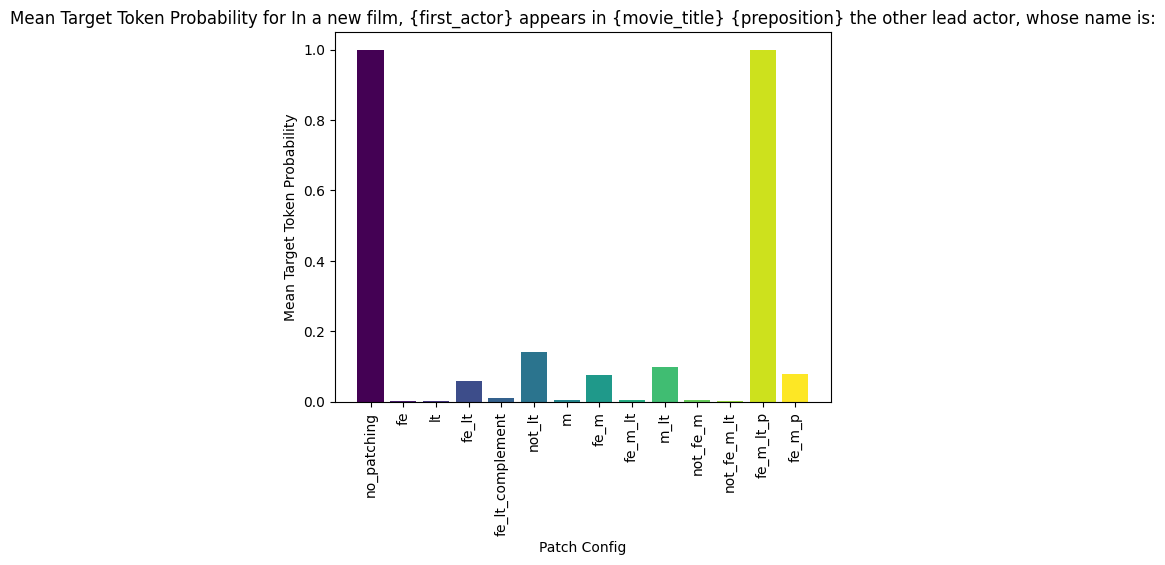

In [47]:
for s_idx, sentence_template in enumerate(test_sentences):
    if s_idx not in results_dict:
        continue

    means = {}
    for patch_filename, results in results_dict[s_idx].items():
        target_probs = results["target_token_probs"]
        mean_prob = sum(target_probs) / len(target_probs) if target_probs else 0
        means[patch_filename] = mean_prob
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    plt.bar(means.keys(), means.values(), color=colors)
    plt.title(f"Mean Target Token Probability for {sentence_template}")
    plt.xlabel("Patch Config")
    plt.ylabel("Mean Target Token Probability")
    plt.xticks(rotation=90)
    plt.show()

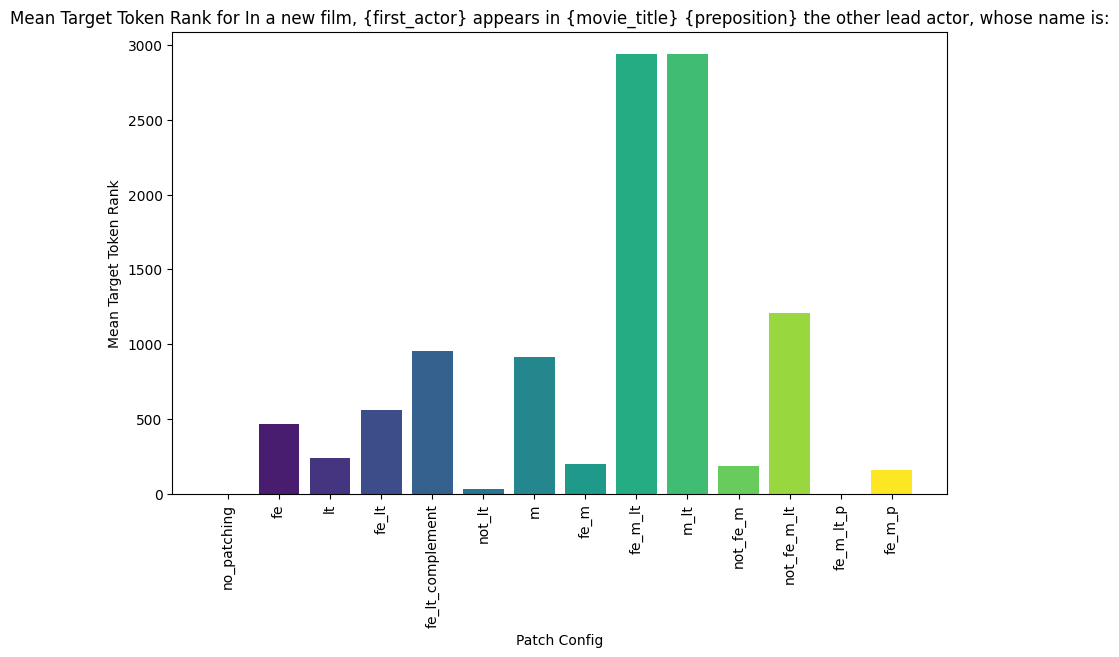

In [52]:
for s_idx, sentence_template in enumerate(test_sentences):
    if s_idx not in results_dict:
        continue

    # Collect means for average ranks
    means = {}
    for patch_filename, results in results_dict[s_idx].items():
        target_ranks = results["target_token_ranks"]
        mean_rank = sum(target_ranks) / len(target_ranks) if target_ranks else 0
        means[patch_filename] = mean_rank
    
    # Plot
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    plt.figure(figsize=(10, 6))
    plt.bar(means.keys(), means.values(), color=colors)
    plt.title(f"Mean Target Token Rank for {sentence_template}")
    plt.xlabel("Patch Config")
    plt.ylabel("Mean Target Token Rank")
    plt.xticks(rotation=90)
    plt.show()

### Previous Experiments

In [19]:
patches_list = []
for ex, inputs in zip(examples, input_list):
    patches = get_patches(
        ex, patch_config, n_layers, tokenizer, inputs["input_ids"], test_sentence_template
    )
    patches_list.append(patches)
patches

2025-05-10 16:08:34,941 - INFO - Overriding previous patch at index 6 with token_idx
2025-05-10 16:08:34,943 - INFO - Overriding previous patch at index 7 with token_idx
2025-05-10 16:08:34,944 - INFO - Overriding previous patch at index 8 with token_idx
2025-05-10 16:08:34,946 - INFO - Overriding previous patch at index 10 with token_idx
2025-05-10 16:08:34,947 - INFO - Overriding previous patch at index 7 with token_idx


{0: Patch(patch_token_idx=0, patch_layers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], targets=PatchTargets(embeddings=True, q=True, k=False, v=False, o=True, gate=True, mlp_up=True, mlp_down=False, ln_1=False, ln_2=False)),
 1: Patch(patch_token_idx=1, patch_layers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], targets=PatchTargets(embeddings=True, q=True, k=False, v=False, o=True, gate=True, mlp_up=True, mlp_down=False, ln_1=False, ln_2=False)),
 2: Patch(patch_token_idx=2, patch_layers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], targets=PatchTargets(embeddings=True, q=True, 

In [20]:
patch_direction = "sft2pre"
# patch_direction = "pre2sft"

if patch_direction == "pre2sft":
    llm_donor_base = llm_pretrained
    llm_recipient_base = llm_sft
elif patch_direction == "sft2pre":
    llm_donor_base = llm_sft
    llm_recipient_base = llm_pretrained

In [21]:
probs_list = []

for inputs, patches in zip(input_list, patches_list):
    probs, dropout = run_patched_inference(
        inputs,
        patches,
        llm_donor_base,
        llm_recipient_base,
        model_config,
        tokenizer,
        # log_patches=True,
    )
    probs_list.append(probs)

In [22]:
target_key = "second_actor"
top_k = 5
topk_indices_list= []

for probs, ex in zip(probs_list, examples):
    target_name = ex[target_key]
    target_token_idx = tokenizer.encode(
        " " + target_name, add_special_tokens=False
    )[0]
    target_token = tokenizer.decode(target_token_idx)

    topk_probs, topk_indices = torch.topk(probs, top_k)
    target_token_prob = probs[target_token_idx].item()
    topk_indices_list.append(topk_indices)

    print(target_token, target_token_prob)

 An 0.5247137546539307
 Paige 0.15547513961791992
 Patrick 0.09634223580360413
 Ut 0.9946710467338562
 Susan 0.8855178356170654


In [23]:
for idx, topk_indices in enumerate(topk_indices_list):
    print(f"### Topk indices: {idx + 1} ###")
    for idx in range(top_k):
        print(f"{tokenizer.decode(topk_indices[idx])}: {topk_probs[idx].item()}")

### Topk indices: 1 ###
 An: 0.8855178356170654
 Alexander: 0.010135998018085957
 T: 0.009486132301390171
 M: 0.004696177318692207
 L: 0.004530440550297499
### Topk indices: 2 ###
 Paige: 0.8855178356170654
 Ros: 0.010135998018085957
 Brittany: 0.009486132301390171
 L: 0.004696177318692207
 Ell: 0.004530440550297499
### Topk indices: 3 ###
 Patrick: 0.8855178356170654
 Kelly: 0.010135998018085957
 L: 0.009486132301390171
 Joe: 0.004696177318692207
 John: 0.004530440550297499
### Topk indices: 4 ###
 Ut: 0.8855178356170654
 E: 0.010135998018085957
 Kelly: 0.009486132301390171
 Tr: 0.004696177318692207
 Ed: 0.004530440550297499
### Topk indices: 5 ###
 Susan: 0.8855178356170654
 Linda: 0.010135998018085957
 L: 0.009486132301390171
 Sarah: 0.004696177318692207
 Miranda: 0.004530440550297499
